In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

# model summary info
from torchsummary import summary

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

C:\Users\DOANTR~1\AppData\Local\Temp/ipykernel_22468/1999504556.py:15: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# Create Gaussian blurs with different widths

In [2]:
n_gauss  = 1000
img_size = 91

x    = np.linspace(start=-4, stop=4, num=img_size)
X, Y = np.meshgrid(x, x)

# Initialize tensors containing images and labels
images = torch.zeros(n_gauss, 1, img_size, img_size)
labels = torch.zeros(n_gauss, 3)

for i in range(n_gauss):
    # Location and width parameters
    loc = np.max(x) / 2 + np.random.randn(2) # Center coordinate
    wid = np.random.rand() * 10 + 5          # Width of Gaussian
    
    # Create the Gaussian with random centers
    G =  np.exp(-((X - loc[0]) ** 2 + (Y - loc[1]) ** 2) / wid)
    G += np.random.randn(img_size, img_size) / 10
    
    # Add to the tensor
    images[i, :, :, :] = torch.tensor(G).view(1, img_size, img_size)
    labels[i, :]       = torch.tensor([loc[0], loc[1], wid])

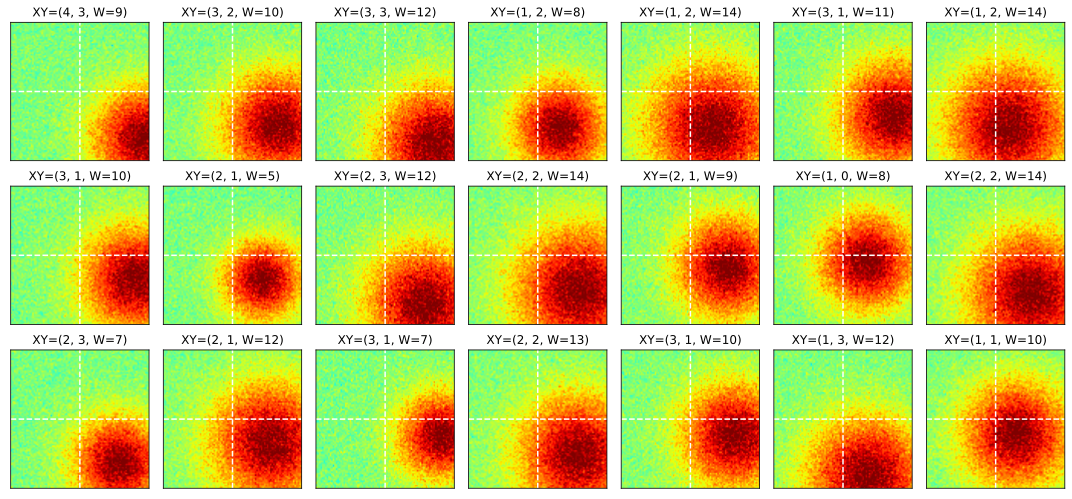

In [5]:
# Visualize some images
fig, axs = plt.subplots(3, 7, figsize=(15, 7))

for i, ax in enumerate(axs.flatten()):
    which_pic = np.random.randint(n_gauss)
    G         = np.squeeze(images[which_pic, :, :])
    ax.imshow(G, vmin=-1, vmax=1, cmap='jet', extent=[-4, 4, -4, 4], origin='upper')
    ax.set_title(f'XY=({labels[which_pic, 0]:.0f}, {labels[which_pic, 1]:.0f}, W={labels[which_pic, 2]:.0f})')
    ax.plot([-4, 4], [0, 0], 'w--')
    ax.plot([0, 0], [-4, 4], 'w--')
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

# Create train/test groups using DataLoader

In [11]:
# Use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(images, labels, test_size=0.1)

# Convert into PyTorch Datasets
train_data_set = TensorDataset(train_data, train_labels)
test_data_set  = TensorDataset(test_data, test_labels)

# Translate into Dataloader objects
batch_size   = 16
train_loader = DataLoader(dataset=train_data_set, batch_size=batch_size,
                        shuffle=True, drop_last=True)
test_loader  = DataLoader(dataset=test_data_set, 
                        batch_size=test_data_set.tensors[0].shape[0])

In [7]:
# Check size (should be images X channels X width X height
print( train_loader.dataset.tensors[0].shape )
print( train_loader.dataset.tensors[1].shape )

torch.Size([900, 1, 91, 91])
torch.Size([900, 3])


# Create the DL model

In [9]:
def make_the_net():
    """
    CNN_FIND_GAUSS
    """
    class gauss_net(nn.Module):
        def __init__(self):
            super().__init__()
            
            # All layers in one go using nn.Sequential
            self.enc = nn.Sequential(
                nn.Conv2d(1, 6, kernel_size=3, padding=1),  # (91 + 2*1 -3)/1 + 1 = 91
                nn.ReLU(),                                  # Treated like a "layer"
                nn.AvgPool2d(2, 2),                         # 91 / 2 = 45
                
                
                nn.Conv2d(6, 4, kernel_size=3, padding=1),  # (45 +2*1 -3)/1 + 1 = 45
                nn.ReLU(),
                nn.AvgPool2d(2, 2),                         # 45 / 2 = 22
                
                nn.Flatten(),                               # Vectorize conv output
                nn.Linear(22 * 22 * 4, 50),                 # 50
                nn.Linear(50, 3)                            # 3
            )
        
        def forward(self, x):
            return self.enc(x)
        
    
    # Create the model instance
    net = gauss_net()
    
    # Loss Function
    loss_func = nn.MSELoss()
    
    # Optimizer
    optimizer = torch.optim.Adam(params=net.parameters(), lr=0.001)
    
    return net, loss_func, optimizer

In [12]:
# Test the model with one batch
net, loss_func, optimizer = make_the_net()

X, y = iter(train_loader).next()
y_hat = net(X)

print(''), print(y_hat.shape)

loss = loss_func(y_hat, y)
print(''), print(f'Loss: {loss}')


torch.Size([16, 3])

Loss: 36.877017974853516


(None, None)

In [13]:
# Count the total number of parameters in the model
summary(model=net, input_data=(1, img_size, img_size))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3]                   --
|    └─Conv2d: 2-1                       [-1, 6, 91, 91]           60
|    └─ReLU: 2-2                         [-1, 6, 91, 91]           --
|    └─AvgPool2d: 2-3                    [-1, 6, 45, 45]           --
|    └─Conv2d: 2-4                       [-1, 4, 45, 45]           220
|    └─ReLU: 2-5                         [-1, 4, 45, 45]           --
|    └─AvgPool2d: 2-6                    [-1, 4, 22, 22]           --
|    └─Flatten: 2-7                      [-1, 1936]                --
|    └─Linear: 2-8                       [-1, 50]                  96,850
|    └─Linear: 2-9                       [-1, 3]                   153
Total params: 97,283
Trainable params: 97,283
Non-trainable params: 0
Total mult-adds (M): 1.08
Input size (MB): 0.03
Forward/backward pass size (MB): 0.44
Params size (MB): 0.37
Estimated Total Size (MB): 0.84


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3]                   --
|    └─Conv2d: 2-1                       [-1, 6, 91, 91]           60
|    └─ReLU: 2-2                         [-1, 6, 91, 91]           --
|    └─AvgPool2d: 2-3                    [-1, 6, 45, 45]           --
|    └─Conv2d: 2-4                       [-1, 4, 45, 45]           220
|    └─ReLU: 2-5                         [-1, 4, 45, 45]           --
|    └─AvgPool2d: 2-6                    [-1, 4, 22, 22]           --
|    └─Flatten: 2-7                      [-1, 1936]                --
|    └─Linear: 2-8                       [-1, 50]                  96,850
|    └─Linear: 2-9                       [-1, 3]                   153
Total params: 97,283
Trainable params: 97,283
Non-trainable params: 0
Total mult-adds (M): 1.08
Input size (MB): 0.03
Forward/backward pass size (MB): 0.44
Params size (MB): 0.37
Estimated Total Size (MB): 0.84

# Create a function that trains the model

In [14]:
def train_the_model():
    """
    CNN_FIND_GAUSS
    """
    
    num_epochs = 30

    # Create a new model
    net, loss_func, optimizer = make_the_net()

    # Initialize
    train_loss = torch.zeros(num_epochs)
    test_loss  = torch.zeros(num_epochs)

    # Loop over epochs
    for epoch_i in range(num_epochs):

        # Loop over training data batches
        batch_loss = [] 

        for X, y in train_loader:
            # Forward pass and loss
            y_hat = net(X)
            loss  = loss_func(y_hat,y)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss from this batch
            batch_loss.append(loss.item())

        # End of batch loop.

        # Get the average training accuracy of the batches
        train_loss[epoch_i] = np.mean(batch_loss)
        
        # Test accuracy
        X, y = next(iter(test_loader)) # Extract X, y from dataloader
        with torch.no_grad():
            y_hat = net(X)
            loss  = loss_func(y_hat, y)
            
        test_loss[epoch_i] = loss.item()

    # End epochs

    return train_loss, test_loss, net

# Run the model and show the results!

In [15]:
train_loss, test_loss, net = train_the_model()

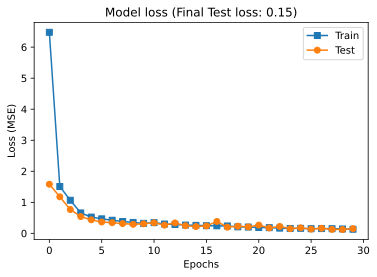

In [16]:
plt.plot(train_loss, 's-', label='Train')
plt.plot(test_loss,  'o-', label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title(f'Model loss (Final Test loss: {test_loss[-1]:.2f})')
plt.show()

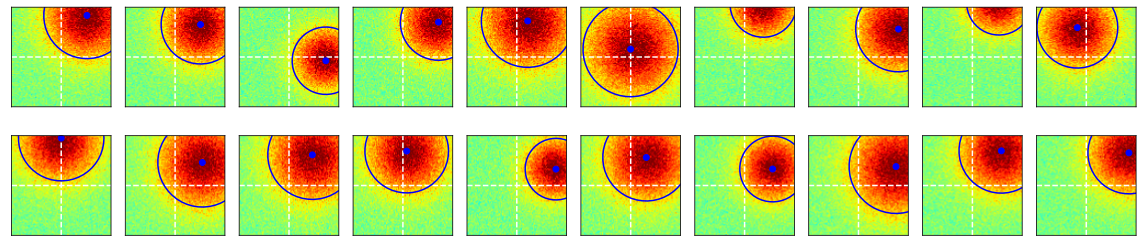

In [18]:
# Visualize some images
X, Y  = next(iter(test_loader))
y_hat = net(X)

fig, axs = plt.subplots(2, 10, figsize=(16, 4))
theta    = np.linspace(start=0, stop=2 * np.pi)

for i, ax in enumerate(axs.flatten()):
    # Get the Gaussian and draw it, and draw the white-guide-line
    G = torch.squeeze(X[i, 0, :, :]).detach()
    ax.imshow(G, vmin=-1, vmax=1, cmap='jet', extent=[-4, 4, -4, 4], origin='lower')
    ax.plot([-4, 4], [0, 0], 'w--')
    ax.plot([0, 0], [-4, 4], 'w--')
    
    # Compute the model's prediction
    cx = y_hat[i][0].item() # Center X
    cy = y_hat[i][1].item() # Center Y
    rd = y_hat[i][2].item() # Radius
    
    # Draw it
    x = cx + np.cos(theta) * np.sqrt(rd)
    y = cy + np.sin(theta) * np.sqrt(rd)
    ax.plot(x,  y,  'b')
    ax.plot(cx, cy, 'bo')
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim([-4, 4])
    ax.set_ylim([-4, 4])

plt.tight_layout()
plt.show()

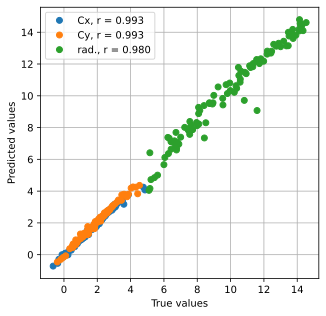

In [19]:
fig         = plt.figure(figsize=(5, 5))
param_names = ['Cx', 'Cy', 'rad.']

for i in range(3):
    # Extract parameters and compute correlation
    yy = Y    [:, i].detach()
    yh = y_hat[:, i].detach()
    cr = np.corrcoef(yy, yh)[0, 1]
    
    plt.plot(yy, yh, 'o', label=f'{param_names[i]}, r = {cr:.3f}')

plt.legend()
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.grid()
plt.show()

# Additional explorations

In [ ]:
# 1) Is this model robust to noise? Explore this by increasing the amount of noise added to each stimulus. You can set
#    this up as a parametric experiment if you want, but you can also do it informally, by changing the gain factor of
#    the noise to see whether performance noticeably declines when the images get noisier. Does changing the noise affect
#    the center coordinates or the width more? And what do the results tell you about the power -- or limitations -- of
#    using CNNs for finding features in images?
# 
# 2) You can see from the code that I didn't change the model architecture -- I literally copy/pasted it from the previous
#    Gaussian codes and only added 3 units at the end. Do you think you can develop a different architecture, possibly
#    simpler, that achieves comparable performance while reducing learning time?
# 